In [51]:
%matplotlib inline

import gym
from gym.wrappers import TimeLimit
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections


from envs.cliff_walking import CliffWalkingEnv
import plotting

matplotlib.style.use('ggplot')

In [52]:
env = TimeLimit(CliffWalkingEnv(), max_episode_steps=200)

The actions is [UP, RIGHT, DOWN, LEFT]

In [54]:
class Config():
    hidden_nodes = 5

In [66]:
class PolicyEstimator():
    """
    Policy Function approximator.
    
    A policy estimator is a function that produce the following distribution
    π(a|s, θ)
    
    s is the current state
    a is an action corresponding 
    θ is the set of parameters, in this case, it is a neural network
    
    Each time, we have two inputs:
        - A state generated by Monte Carlo
        - An action generated by Monte Carlo
    The model would produce (from the state) an output layer
    that correspond to a preference function h(s,a).
    
    Following is the formula for updating:
    
    θ += α*γ^t*G * DELTA_θ (log π(At|St, θ))
    
    or, more succintly, for baseline also:
    
    θ += α * TARGET_WEIGHT * DELTA_θ (log π(At|St, θ))
    
    where TARGET_WEIGHT could be the (discounted) return from time t
    adjusted with baseline.
    
    This corresponding to the following graph:
    
    The graph basically predicts the action probability, BUT the loss function
    needs to be reweighted with the TARGET_WEIGHT, so that the updating 
    follows the formula
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator", config = Config()):
        """
        The code to declare your tensorflow graph comes here
        """
        with tf.variable_scope(scope): 
            "Declare all placeholders"
            "Placeholder for input"
            """
            Now in this case, if the state is represented as a number ranking from
            start point of the map to the end, we lost the locality between
            cells of two consecutive rows.
            So let's make it a row and column.
            """
            # No batch
            self.state = tf.placeholder(shape=[], name="state", dtype = tf.int32)
            
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            
            "Placeholder for Monte Carlo action"
            self.action = tf.placeholder(name="action", dtype = tf.int32)
            
            "Placeholder for target"
            self.target = tf.placeholder(name="target", dtype = tf.float32)
            
            """
            Let's add a hidden layer of n nodes
            with relu
            
            I don't understand why, but I need to expand the input
            to two dimensions
            """
#             self.hidden = tf.contrib.layers.fully_connected(
#                 tf.expand_dims(state_one_hot, 0),
#                 config.hidden_nodes,
#                 activation_fn=None,
#                 weights_initializer=tf.zeros_initializer)
            
            """
            Output is also another fully connected layer
            This is the preference function
            h(s) = for a [h(s,a)]
            """
            self.output_layer = tf.contrib.layers.fully_connected(
                tf.expand_dims(state_one_hot, 0),
                env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
#             self.output_layer = tf.contrib.layers.fully_connected(
#                 inputs=tf.expand_dims(self.state, 0),
#                 num_outputs=env.action_space.n,
#                 activation_fn=None,
#                 weights_initializer=tf.zeros_initializer)
            
            # After doing softmax, squeeze to reduce dimension to flat
            self.probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            
            self.picked_action_prob = tf.gather(self.probs, self.action)
            
            # This actually recalculate self.probs
            self.loss = -tf.log(self.picked_action_prob) * self.target
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        """
        In prediction, just need to produce the action distribution
        """
        sess = sess or tf.get_default_session()
        return sess.run(self.probs, {self.state: state})
    
    def update(self, state, target, action, sess=None):
        """
        state: input state
        target: final return of an episode
        action: input action
        
        We need to run train_op to update the parameters
        We also need to return its loss
        """
        sess = sess or tf.get_default_session()
        _, loss = sess.run([self.train_op, self.loss], {self.state: state, self.action: action, self.target: target})
        
        return loss

In [107]:
class ValueEstimator():
    """
    Value Function approximator.
    
    This is to calculate the baseline, otherwise Policy Estimator is enough
    
    We need another set of parameter w for state-value approximator.
    
    Target is (discounted) return
    
    Just use a very simple linear fully connected layer between state and output
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        """
        """
        with tf.variable_scope(scope): 
            # No batch
            self.state = tf.placeholder(shape=[], name="state", dtype = tf.int32)
            
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            
            "Placeholder for target"
            self.target = tf.placeholder(name="target", dtype = tf.float32)
            
            self.scale = tf.placeholder(name="scale", dtype = tf.float32)
            
            self.output_layer = tf.contrib.layers.fully_connected(
                tf.expand_dims(state_one_hot,0),
                1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.value = tf.squeeze(self.output_layer)
            
            self.loss = tf.squared_difference(self.value, self.target) * self.scale
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        """
        """
        sess = sess or tf.get_default_session()
        return sess.run(self.value, {self.state: state})

    def update(self, state, target, scale = 1, sess=None):
        """
        """
        sess = sess or tf.get_default_session()
        _, loss = sess.run([self.train_op, self.loss], {self.state: state, self.target: target, self.scale: scale})
        
        return loss

In [97]:
# state is from 0 to 47
# here we get a (row, column):
def state_to_cell(state_value):
    row = state_value // 12
    col = state_value % 12
    return (row, col)

In [117]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            sys.stdout.flush()

            if done:
                break
                
            state = next_state
        
        accumulate_reward = 0
        
        # Go from backward
        for t in range(len(episode)-1, -1, -1):
            state, action, reward, _, _ = episode[t]
            # G_t
            accumulate_reward = accumulate_reward * discount_factor + reward
            
            """
            IMPORTANT:
            
            The order between these two next commands are very important
            Predict before update:
            and the average stuck at -100 which means that
            the algorithm never find the target
            
            Update before predict:
            It would converge correctly
            
            ===== Possible explanation ======
            If I update before predict
            
            the baseline is much closer to correct value
            advantage therefore is much smaller
            
            In the book, the algorithm is as following:
            do predict before update
            add a scaling factor correspond to the advantage
            
            """
            estimator_value.update(state, accumulate_reward)
            
            predicted_reward = estimator_value.predict(state)
            
            
            # advantage
            advantage = accumulate_reward - predicted_reward
            
            estimator_policy.update(state, discount_factor ** t * advantage, action)
            
    return stats

In [118]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)
    
    for state in range(48):
        print((state_to_cell(state), policy_estimator.predict(state)))


Step 12 @ Episode 2000/2000 (-15.0))((0, 0), array([  6.98872423e-03,   9.91840363e-01,   5.35662402e-04,
         6.35236443e-04], dtype=float32))
((0, 1), array([  7.11094774e-03,   9.90835071e-01,   1.68374728e-03,
         3.70194495e-04], dtype=float32))
((0, 2), array([  1.04813911e-02,   9.88678873e-01,   5.10474201e-04,
         3.29340284e-04], dtype=float32))
((0, 3), array([  1.50073841e-02,   9.84198451e-01,   4.16816300e-04,
         3.77288612e-04], dtype=float32))
((0, 4), array([  3.46191274e-03,   9.96229708e-01,   1.14599075e-04,
         1.93745072e-04], dtype=float32))
((0, 5), array([  1.93946098e-03,   9.97736573e-01,   1.94913911e-04,
         1.29003209e-04], dtype=float32))
((0, 6), array([  8.20336211e-03,   9.90819871e-01,   7.20092910e-04,
         2.56607716e-04], dtype=float32))
((0, 7), array([  1.06010707e-02,   9.89216566e-01,   8.97729769e-05,
         9.26089051e-05], dtype=float32))
((0, 8), array([  2.76693795e-03,   9.96768594e-01,   1.67991238e-04

'\nIMPORTANT\nResults as the following is calculated when predict comes before update\n'

In [100]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 500, discount_factor=1.0)
    
    for state in range(48):
        print((state_to_cell(state), policy_estimator.predict(state)))

Step 24 @ Episode 500/500 (-21.0))((0, 0), array([ 0.28631395,  0.67763084,  0.01910216,  0.01695299], dtype=float32))
((0, 1), array([ 0.50321627,  0.4197301 ,  0.05941492,  0.0176388 ], dtype=float32))
((0, 2), array([ 0.23435706,  0.70988357,  0.03949328,  0.01626611], dtype=float32))
((0, 3), array([ 0.19384053,  0.77452546,  0.01591809,  0.01571586], dtype=float32))
((0, 4), array([ 0.37670064,  0.56035817,  0.03884871,  0.0240925 ], dtype=float32))
((0, 5), array([ 0.13143034,  0.84253407,  0.0174409 ,  0.00859472], dtype=float32))
((0, 6), array([ 0.09149837,  0.87929076,  0.01260578,  0.01660499], dtype=float32))
((0, 7), array([ 0.13771573,  0.8067205 ,  0.03479404,  0.02076968], dtype=float32))
((0, 8), array([ 0.0639675 ,  0.89203435,  0.03360072,  0.01039745], dtype=float32))
((0, 9), array([ 0.14993083,  0.82127202,  0.02100747,  0.0077897 ], dtype=float32))
((0, 10), array([ 0.19011179,  0.29231763,  0.50168717,  0.01588342], dtype=float32))
((0, 11), array([ 0.25081497, 

In [104]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 500, discount_factor=1.0)
    
    for state in range(48):
        print((state_to_cell(state), policy_estimator.predict(state)))

Step 40 @ Episode 500/500 (-105.0)((0, 0), array([ 0.20443843,  0.27650297,  0.29012808,  0.22893047], dtype=float32))
((0, 1), array([ 0.20322658,  0.27950692,  0.30437917,  0.21288727], dtype=float32))
((0, 2), array([ 0.20251571,  0.28798041,  0.29721197,  0.2122919 ], dtype=float32))
((0, 3), array([ 0.21701466,  0.27361193,  0.29172441,  0.217649  ], dtype=float32))
((0, 4), array([ 0.20238449,  0.2939727 ,  0.28591862,  0.2177242 ], dtype=float32))
((0, 5), array([ 0.1835023 ,  0.32439709,  0.27649897,  0.21560162], dtype=float32))
((0, 6), array([ 0.22815633,  0.26857123,  0.30115315,  0.20211925], dtype=float32))
((0, 7), array([ 0.20190103,  0.30992043,  0.27671364,  0.21146491], dtype=float32))
((0, 8), array([ 0.19559364,  0.29043218,  0.30428305,  0.20969115], dtype=float32))
((0, 9), array([ 0.20119146,  0.26969919,  0.32328814,  0.20582131], dtype=float32))
((0, 10), array([ 0.20376825,  0.27137527,  0.28502205,  0.23983443], dtype=float32))
((0, 11), array([ 0.21064107, 

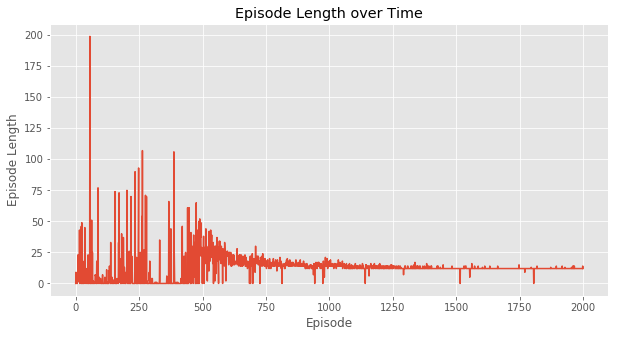

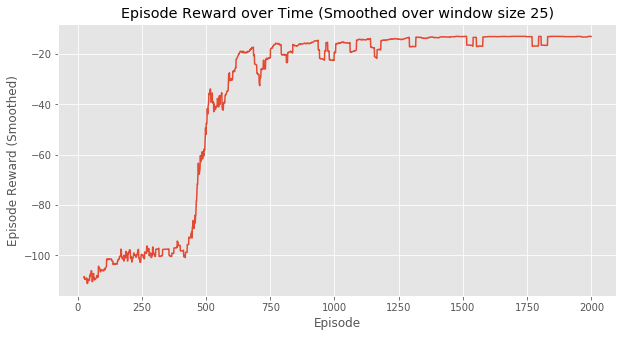

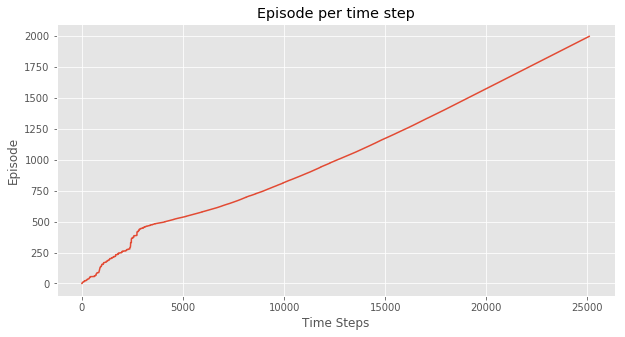

(<matplotlib.figure.Figure at 0x18503b5e198>,
 <matplotlib.figure.Figure at 0x18506a03198>)

In [119]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [120]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor critic algorithm is nearly identical to REINFORCE with baseline,
    but instead of using the Return, we use the predicted 
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    I = 1
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            sys.stdout.flush()
            
            """
            First, predict for S'
            Second, update for S
            Third, predict for S
            """
            predicted_next_state_value = estimator_value.predict(next_state)
            td_target = reward + discount_factor * predicted_next_state_value
            estimator_value.update(state, td_target)
            
            predicted_target = estimator_value.predict(state)
            
            """
            Implement update write away
            """
            # advantage
            advantage = td_target - predicted_target
            
            estimator_policy.update(state, I * advantage, action)
            
            if done:
                break
            
            I *= discount_factor
            state = next_state
        
    return stats

In [123]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 1000, discount_factor=1.0)
    
    for state in range(48):
        print((state_to_cell(state), policy_estimator.predict(state)))

Step 1 @ Episode 1000/1000 (-107.0)((0, 0), array([ 0.15778032,  0.31699306,  0.30860499,  0.21662171], dtype=float32))
((0, 1), array([ 0.16849987,  0.33106574,  0.30326867,  0.19716577], dtype=float32))
((0, 2), array([ 0.16711067,  0.33165976,  0.29162684,  0.20960279], dtype=float32))
((0, 3), array([ 0.17872915,  0.31061262,  0.29179475,  0.21886352], dtype=float32))
((0, 4), array([ 0.15704165,  0.31630015,  0.31148672,  0.2151714 ], dtype=float32))
((0, 5), array([ 0.17435221,  0.31572342,  0.30148292,  0.20844159], dtype=float32))
((0, 6), array([ 0.17801343,  0.30270186,  0.29637152,  0.22291315], dtype=float32))
((0, 7), array([ 0.1683784 ,  0.31518421,  0.3231214 ,  0.19331594], dtype=float32))
((0, 8), array([ 0.17309198,  0.32890841,  0.28974065,  0.20825894], dtype=float32))
((0, 9), array([ 0.16735025,  0.31656179,  0.30189148,  0.21419649], dtype=float32))
((0, 10), array([ 0.16735025,  0.31656179,  0.30189148,  0.21419649], dtype=float32))
((0, 11), array([ 0.16735025,

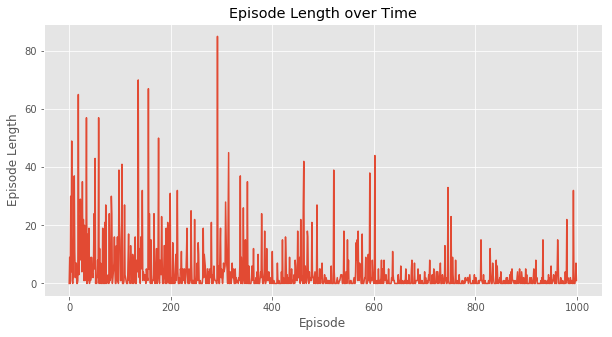

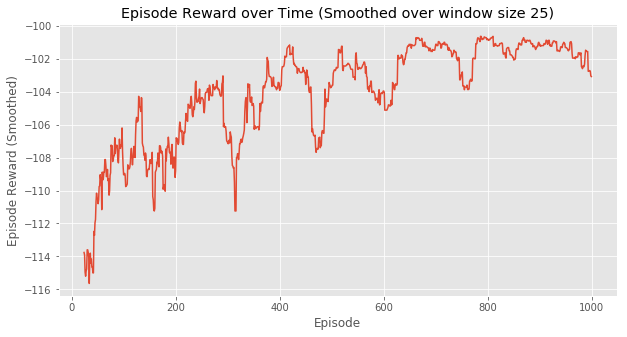

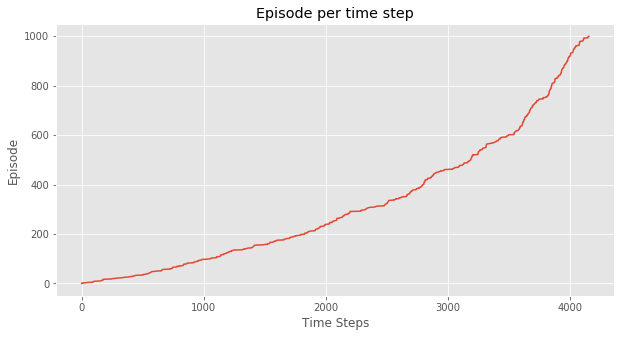

(<matplotlib.figure.Figure at 0x18505255828>,
 <matplotlib.figure.Figure at 0x18505285588>)

In [124]:
plotting.plot_episode_stats(stats, smoothing_window=25)